## Group 15

#### Shivani Katta (UBID: 50412911)
#### Ranga Sai Saran Rohit Tananki (UBID: 50441793)
#### Sahithi Dodda (UBID: 50441731)
#### Vikas Kodakandla (UBID:  50442144)

### New York State Statewide COVID-19 Testing Dataset

In [1]:
import pandas as pd
import sqlite3
from sqlite3 import Error

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [2]:
# df = pd.read_csv('New_York_State_Statewide_COVID-19_Testing.csv')
# display(df)

In [3]:
data_filename='New_York_State_Statewide_COVID-19_Testing.csv'
header = 0
res = []
i=0
with open(data_filename) as file:
    for l in file:
        if not l.strip():
            continue
        if not header:
            header = 1
            continue
        l = l.strip().split(',')
        res.append(l)

create_table_covidtest_sql = """CREATE TABLE [COVID_TESTS] (
[Test_Date] DATE NOT NULL,
[County] TEXT,
[New_Positives] INTEGER,
[Cumulative_Number_of_Positives] INTEGER,
[Total_Number_of_Tests_Performed] INTEGER,
[Cumulative_Number_of_Tests_Performed] INTEGER,
[Test_Positive_Perc] TEXT,
[Geography] TEXT
)"""

conn_un_normalized = create_connection('un_normalized_covid.db')
create_table(conn_un_normalized, create_table_covidtest_sql, 'COVID_TESTS')

with conn_un_normalized:
    insert_values_covidtests = ''' INSERT INTO COVID_TESTS(Test_Date,County,New_Positives,Cumulative_Number_of_Positives,
    Total_Number_of_Tests_Performed,Cumulative_Number_of_Tests_Performed,Test_Positive_Perc,Geography)
                    VALUES(?,?,?,?,?,?,?,?) '''
    cur = conn_un_normalized.cursor()
    cur.executemany(insert_values_covidtests , res)   

In [4]:
sql_statement = "SELECT * FROM COVID_TESTS"
df = pd.read_sql_query(sql_statement, conn_un_normalized)
df

,Test_Date,County,New_Positives,Cumulative_Number_of_Positives,Total_Number_of_Tests_Performed,Cumulative_Number_of_Tests_Performed,Test_Positive_Perc,Geography
0,5/11/2022,Albany,220,63461,1591,1280510,13.85%,COUNTY
1,5/10/2022,Albany,148,63241,1099,1278919,15.33%,COUNTY
2,5/9/2022,Albany,112,63093,679,1277820,16.05%,COUNTY
3,5/8/2022,Albany,112,62981,879,1277141,13.50%,COUNTY
4,5/7/2022,Albany,129,62869,1180,1276262,11.15%,COUNTY
...,...,...,...,...,...,...,...,...
60145,3/5/2020,Yates,0,0,0,0,0.00%,COUNTY
60146,3/4/2020,Yates,0,0,0,0,0.00%,COUNTY
60147,3/3/2020,Yates,0,0,0,0,0.00%,COUNTY
60148,3/2/2020,Yates,0,0,0,0,0.00%,COUNTY


In [5]:
conn_un_normalized_covid = create_connection('un_normalized_covid.db')
conn_normalized_covid_data = create_connection('normalized_covid_data.db')

In [6]:
sql_statement = "select DISTINCT County from COVID_TESTS;"
list_county = execute_sql_statement(sql_statement,conn_un_normalized_covid)

create_table_County_sql = """CREATE TABLE [COUNTY] (
        [COUNTYID] INTEGER PRIMARY KEY NOT NULL,
        [COUNTY] TEXT NOT NULL
    );"""
    

create_table(conn_normalized_covid_data,create_table_County_sql,'COUNTY')

def insert_county(conn, values):
        sql = ''' INSERT INTO COUNTY(COUNTY)
                VALUES(?) '''
        cur = conn.cursor()
        cur.execute(sql, values)
        return cur.lastrowid

with conn_normalized_covid_data:
    for row in list_county:
        insert_county(conn_normalized_covid_data,(row[0],))

In [7]:
sql_statement = "SELECT * FROM COUNTY"
df = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
df

,COUNTYID,COUNTY
0,1,Albany
1,2,Allegany
2,3,Bronx
3,4,Broome
4,5,Capital Region
...,...,...
69,70,Wayne
70,71,Westchester
71,72,Western New York
72,73,Wyoming


In [8]:
county_to_countyid_dict = {}
county_and_id = 'SELECT COUNTYID,COUNTY from COUNTY'
res_county = execute_sql_statement(county_and_id, conn_normalized_covid_data)
for r in res_county:
#     print(r)
    county_to_countyid_dict[r[1]] = r[0]
print(county_to_countyid_dict)

{'Albany': 1, 'Allegany': 2, 'Bronx': 3, 'Broome': 4, 'Capital Region': 5, 'Cattaraugus': 6, 'Cayuga': 7, 'Central New York': 8, 'Chautauqua': 9, 'Chemung': 10, 'Chenango': 11, 'Clinton': 12, 'Columbia': 13, 'Cortland': 14, 'Delaware': 15, 'Dutchess': 16, 'Erie': 17, 'Essex': 18, 'Finger Lakes': 19, 'Franklin': 20, 'Fulton': 21, 'Genesee': 22, 'Greene': 23, 'Hamilton': 24, 'Herkimer': 25, 'Jefferson': 26, 'Kings': 27, 'Lewis': 28, 'Livingston': 29, 'Long Island': 30, 'Madison': 31, 'Mid-Hudson': 32, 'Mohawk Valley': 33, 'Monroe': 34, 'Montgomery': 35, 'Nassau': 36, 'New York': 37, 'New York City': 38, 'Niagara': 39, 'North Country': 40, 'Oneida': 41, 'Onondaga': 42, 'Ontario': 43, 'Orange': 44, 'Orleans': 45, 'Oswego': 46, 'Otsego': 47, 'Out-of-State': 48, 'Putnam': 49, 'Queens': 50, 'Rensselaer': 51, 'Richmond': 52, 'Rockland': 53, 'STATEWIDE': 54, 'Saratoga': 55, 'Schenectady': 56, 'Schoharie': 57, 'Schuyler': 58, 'Seneca': 59, 'Southern Tier': 60, 'St. Lawrence': 61, 'Steuben': 62, 

In [9]:
sql_statement = "select Test_Date,County from COVID_TESTS;"
list_date_county = execute_sql_statement(sql_statement,conn_un_normalized_covid)

create_table_date_sql = """CREATE TABLE [DATE_COUNTY] (
        [Test_ID] INTEGER PRIMARY KEY NOT NULL,
        [Test_Date] DATE NOT NULL,
        [County_ID] INTEGER NOT NULL
    );"""
    

create_table(conn_normalized_covid_data,create_table_date_sql,'DATE_COUNTY')

def insert_date_county(conn, values):
        sql = ''' INSERT INTO DATE_COUNTY(Test_Date,County_ID)
                VALUES(?,?) '''
        cur = conn.cursor()
        cur.execute(sql, values)
        return cur.lastrowid

with conn_normalized_covid_data:
    for row in list_date_county:
#         print(row)
#         print(county_to_countyid_dict[row[1]])
        insert_date_county(conn_normalized_covid_data,(row[0],county_to_countyid_dict[row[1]]))

FOREIGN KEY constraint failed
table [DATE_COUNTY] already exists


In [10]:
sql_statement = "SELECT * FROM DATE_COUNTY "
df = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
df

,Test_ID,Test_Date,County_ID
0,1,05/11/2022,1
1,2,05/10/2022,1
2,3,05/09/2022,1
3,4,05/08/2022,1
4,5,05/07/2022,1
...,...,...,...
421045,421046,3/5/2020,74
421046,421047,3/4/2020,74
421047,421048,3/3/2020,74
421048,421049,3/2/2020,74


In [11]:

sql_statement = "select DISTINCT Geography from COVID_TESTS;"
list_geography = execute_sql_statement(sql_statement,conn_un_normalized_covid)

# drop_sql = "DROP TABLE Geography"
# execute_sql_statement(drop_sql,conn_normalized_covid_data)

create_table_Geography_sql = """CREATE TABLE [Geography] (
        [GeographyID] INTEGER PRIMARY KEY NOT NULL,
        [Geography] TEXT NOT NULL
    );"""
    

# create_table(conn_normalized_covid_data,create_table_Geography_sql,'Geography')
create_table(conn_normalized_covid_data,create_table_Geography_sql,'Geography')

def insert_geography(conn, values):
        sql = ''' INSERT INTO Geography(Geography)
                VALUES(?) '''
        cur = conn.cursor()
        cur.execute(sql, values)
        return cur.lastrowid

with conn_normalized_covid_data:
    for row in list_geography:
        insert_geography(conn_normalized_covid_data,(row[0],))

FOREIGN KEY constraint failed
table [Geography] already exists


In [12]:
sql_statement = "SELECT * FROM Geography "
df = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
df

,GeographyID,Geography
0,1,COUNTY
1,2,REGION
2,3,STATEWIDE
3,4,COUNTY
4,5,REGION
5,6,STATEWIDE
6,7,COUNTY
7,8,REGION
8,9,STATEWIDE
9,10,COUNTY


In [13]:
geo_to_geoid_dict = {}
geo_and_id = 'SELECT GeographyID,Geography from Geography'
res_geo = execute_sql_statement(geo_and_id, conn_normalized_covid_data)
for r in res_geo:
#     print(r)
    geo_to_geoid_dict[r[1]] = r[0]
print(geo_to_geoid_dict)

{'COUNTY': 19, 'REGION': 20, 'STATEWIDE': 21}


In [14]:
sql_statement = """select New_Positives,Cumulative_Number_of_Positives,Total_Number_of_Tests_Performed,Cumulative_Number_of_Tests_Performed,
Test_Positive_Perc,Geography from COVID_TESTS;"""
list_data = execute_sql_statement(sql_statement,conn_un_normalized_covid)

create_table_covidresult_sql = """CREATE TABLE [COVID_RESULTS] (
        [Test_ID] INTEGER PRIMARY KEY NOT NULL,
        [New_Positives] INTEGER,
        [Cumulative_Number_of_Positives] INTEGER,
        [Total_Number_of_Tests_Performed] INTEGER,
        [Cumulative_Number_of_Tests_Performed] INTEGER,
        [Test_Positive_Perc] TEXT,
        [GeographyID] INTEGER,
        FOREIGN KEY(Test_ID) REFERENCES DATE_COUNTY(Test_ID),
        FOREIGN KEY(GeographyID) REFERENCES Geography(GeographyID)
    );"""
    

create_table(conn_normalized_covid_data,create_table_covidresult_sql,'COVID_RESULTS')

def insert_covid_result(conn, values):
        sql = ''' INSERT INTO COVID_RESULTS(New_Positives,Cumulative_Number_of_Positives,
    Total_Number_of_Tests_Performed,Cumulative_Number_of_Tests_Performed,Test_Positive_Perc,GeographyID)
                    VALUES(?,?,?,?,?,?) '''
        cur = conn.cursor()
        cur.execute(sql, values)
        return cur.lastrowid

with conn_normalized_covid_data:
    for row in list_data:
#         print(row)
#         print(county_to_countyid_dict[row[1]])
        insert_covid_result(conn_normalized_covid_data,(row[0],row[1],row[2],row[3],row[4],geo_to_geoid_dict[row[5]]))

In [15]:
sql_statement = "SELECT * FROM COVID_RESULTS "
df = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
df

,Test_ID,New_Positives,Cumulative_Number_of_Positives,Total_Number_of_Tests_Performed,Cumulative_Number_of_Tests_Performed,Test_Positive_Perc,GeographyID
0,1,220,63461,1591,1280510,13.85%,19
1,2,148,63241,1099,1278919,15.33%,19
2,3,112,63093,679,1277820,16.05%,19
3,4,112,62981,879,1277141,13.50%,19
4,5,129,62869,1180,1276262,11.15%,19
...,...,...,...,...,...,...,...
60145,60146,0,0,0,0,0.00%,19
60146,60147,0,0,0,0,0.00%,19
60147,60148,0,0,0,0,0.00%,19
60148,60149,0,0,0,0,0.00%,19


In [16]:
sql_statement = "SELECT * FROM COVID_RESULTS "
df = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
df

,Test_ID,New_Positives,Cumulative_Number_of_Positives,Total_Number_of_Tests_Performed,Cumulative_Number_of_Tests_Performed,Test_Positive_Perc,GeographyID
0,1,220,63461,1591,1280510,13.85%,19
1,2,148,63241,1099,1278919,15.33%,19
2,3,112,63093,679,1277820,16.05%,19
3,4,112,62981,879,1277141,13.50%,19
4,5,129,62869,1180,1276262,11.15%,19
...,...,...,...,...,...,...,...
60145,60146,0,0,0,0,0.00%,19
60146,60147,0,0,0,0,0.00%,19
60147,60148,0,0,0,0,0.00%,19
60148,60149,0,0,0,0,0.00%,19


# Data Visualization

### Use Case1: Top 15 counties with highest number of positive cases

In [17]:
sql_statement = """SELECT 
    c.COUNTY, r.Cumulative_Number_of_Positives
FROM 
    COVID_RESULTS r
INNER JOIN 
    DATE_COUNTY d ON r.Test_ID = d.Test_ID
INNER JOIN
    COUNTY c ON d.County_ID = c.COUNTYID
INNER JOIN
    Geography g ON r.GeographyID = g.GeographyID
WHERE Test_Date = '05/11/2022' AND g.Geography = 'COUNTY' ORDER BY -r.Cumulative_Number_of_Positives LIMIT 15;"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,COUNTY,Cumulative_Number_of_Positives
0,Kings,720568
1,Queens,667393
2,New York,444837
3,Suffolk,444799
4,Nassau,425386
5,Bronx,404527
6,Westchester,264448
7,Erie,227059
8,Richmond,169697
9,Monroe,163463


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Text(0.5, 1.0, 'Pie Chart')

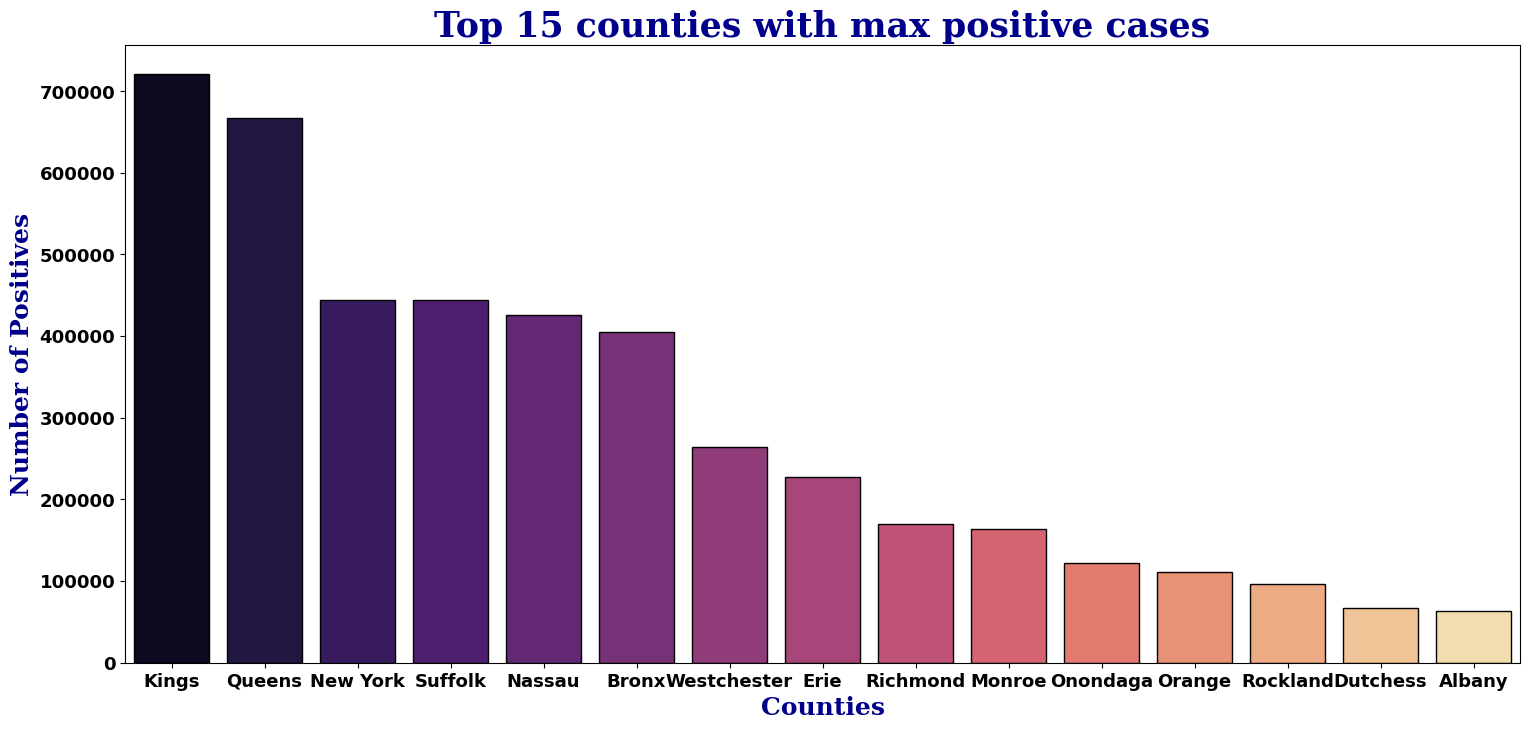

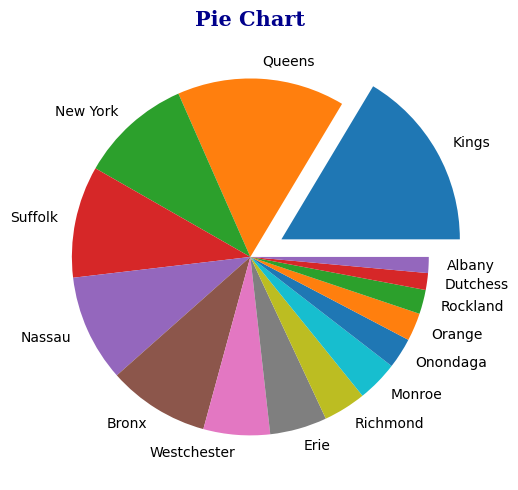

In [19]:
## Bar Graph
plt.figure(figsize=(18,18),dpi=100)
plt.subplot(2, 1, 1)
sns.barplot(y=data_frame["Cumulative_Number_of_Positives"],x=data_frame["COUNTY"], palette = "magma",edgecolor='black')
font1 = {'family':'serif','color':'darkblue','size':25, 'fontweight':'bold'}
font2 = {'family':'serif','color':'darkblue','size':18, 'fontweight':'bold'}
plt.ylabel("Number of Positives", fontdict = font2)
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.xlabel("Counties", fontdict = font2)
plt.title("Top 15 counties with max positive cases",fontdict = font1)

## Pie chart
plt.figure(figsize=(13, 13),dpi=100)
x = np.array(data_frame["COUNTY"])
y = np.array(data_frame["Cumulative_Number_of_Positives"])
plt.subplot(2, 1, 2)
plt.pie(y, labels = x, explode = [0.2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
font1 = {'family':'serif','color':'darkblue','size':15, 'fontweight':'bold'}
plt.title("Pie Chart",fontdict = font1)

### Use Case 2.1: 15 Counties with Highest total tests performed in 2022 VS positive cases in 2022

In [20]:
sql_statement = """SELECT c.COUNTY as County, SUM(r.Total_Number_of_Tests_Performed) as Total_Tests, SUM(r.New_Positives) as Total_positives
    FROM COVID_RESULTS r
    INNER JOIN DATE_COUNTY d USING('Test_ID')
    INNER JOIN COUNTY c ON d.County_ID = c.COUNTYID
    INNER JOIN Geography g ON r.GeographyID = g.GeographyID
    WHERE d.Test_Date LIKE '%22' AND g.Geography = 'COUNTY' GROUP BY c.COUNTY ORDER BY -Total_Tests LIMIT 15;"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,County,Total_Tests,Total_positives
0,Kings,3727496,238239
1,New York,2716020,163745
2,Queens,2687100,233055
3,Bronx,1648871,128602
4,Nassau,1184678,123020
5,Suffolk,1134662,117761
6,Westchester,868890,77709
7,Richmond,589133,48699
8,Erie,575432,75797
9,Rockland,490815,27901


Text(0.5, 1.0, 'Pie Chart for the year 2022')

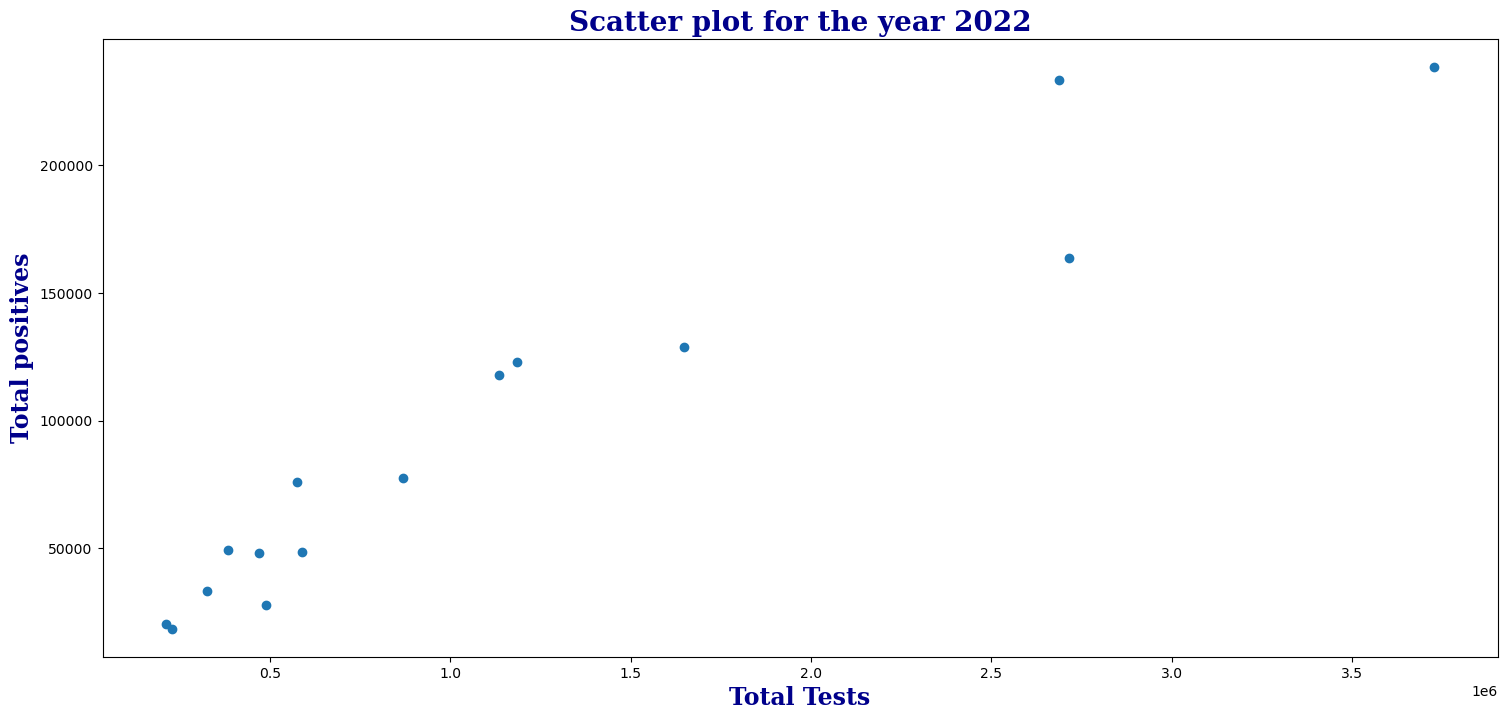

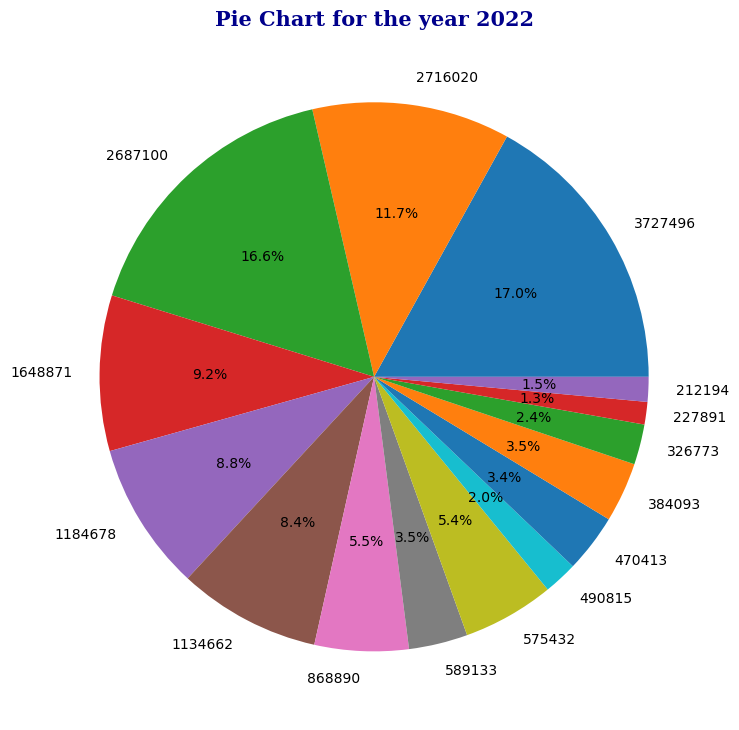

In [21]:
## Scatter plot
plt.figure(figsize=(18, 18),dpi=100)
x = np.array(data_frame["Total_Tests"])
y = np.array(data_frame["Total_positives"])

plt.subplot(2, 1, 1)
plt.scatter(x, y)
font1 = {'family':'serif','color':'darkblue','size':20, 'fontweight':'bold'}
font2 = {'family':'serif','color':'darkblue','size':17, 'fontweight':'bold'}
plt.title("Scatter plot for the year 2022",fontdict = font1)
plt.xlabel("Total Tests", fontdict = font2)
plt.ylabel("Total positives", fontdict = font2)

## Pie chart
plt.figure(figsize=(20, 20),dpi=100)
x = np.array(data_frame["Total_Tests"])
y = np.array(data_frame["Total_positives"])
plt.subplot(2, 1, 2)
plt.pie(y, labels = x, autopct='%1.1f%%')
font1 = {'family':'serif','color':'darkblue','size':15, 'fontweight':'bold'}
plt.title("Pie Chart for the year 2022",fontdict = font1)



### Use Case 2.2: 15 Counties with Highest total tests performed in 2021 VS positive cases in 2021

In [22]:
sql_statement = """SELECT c.COUNTY as County, SUM(r.Total_Number_of_Tests_Performed) as Total_Tests, SUM(r.New_Positives) as Total_positives
    FROM COVID_RESULTS r
    INNER JOIN DATE_COUNTY d USING('Test_ID')
    INNER JOIN COUNTY c ON d.County_ID = c.COUNTYID
    INNER JOIN Geography g ON r.GeographyID = g.GeographyID
    WHERE d.Test_Date LIKE '%21' AND g.Geography = 'COUNTY' GROUP BY c.COUNTY ORDER BY -Total_Tests LIMIT 15;"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,County,Total_Tests,Total_positives
0,Kings,9292674,358905
1,Queens,7466751,309231
2,New York,7405707,217794
3,Suffolk,4463067,229107
4,Bronx,4427657,191950
5,Nassau,4345623,212906
6,Westchester,2939054,116125
7,Erie,2306990,109274
8,Richmond,1967803,85449
9,Tompkins,1956738,9597


Text(0.5, 1.0, 'Pie Chart for the year 2021')

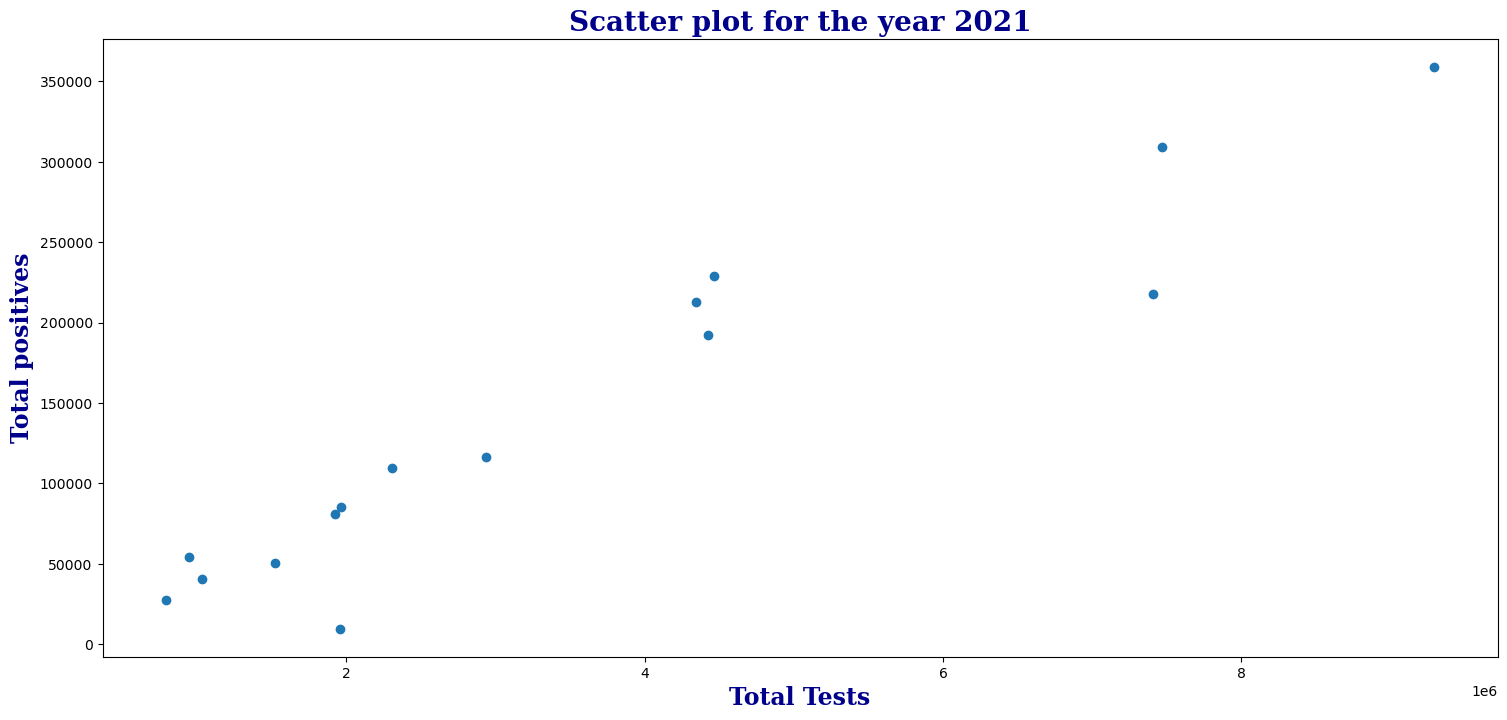

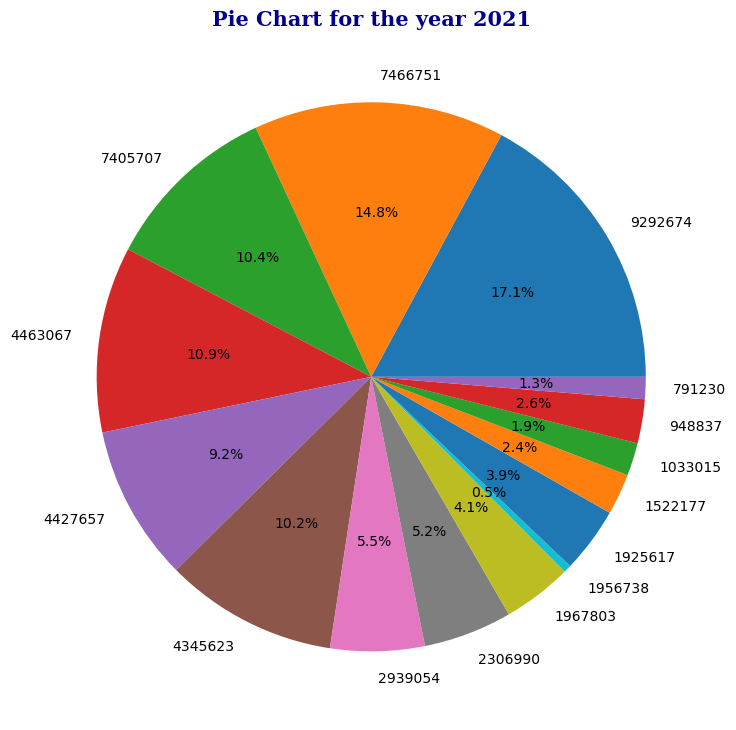

In [23]:
## Scatter plot
plt.figure(figsize=(18, 18),dpi=100)
x = np.array(data_frame["Total_Tests"])
y = np.array(data_frame["Total_positives"])
plt.subplot(2, 1, 1)
plt.scatter(x, y)
font1 = {'family':'serif','color':'darkblue','size':20, 'fontweight':'bold'}
font2 = {'family':'serif','color':'darkblue','size':17, 'fontweight':'bold'}
plt.title("Scatter plot for the year 2021",fontdict = font1)
plt.xlabel("Total Tests", fontdict = font2)
plt.ylabel("Total positives", fontdict = font2)

## Pie chart
plt.figure(figsize=(20, 20),dpi=100)
x = np.array(data_frame["Total_Tests"])
y = np.array(data_frame["Total_positives"])
plt.subplot(2, 1, 2)
plt.pie(y, labels = x, autopct='%1.1f%%')
font1 = {'family':'serif','color':'darkblue','size':15, 'fontweight':'bold'}
plt.title("Pie Chart for the year 2021",fontdict = font1)


### Use Case 2.3: 15 Counties with Highest total tests performed in 2020 VS positive cases in 2020

In [24]:
sql_statement = """SELECT c.COUNTY as County, SUM(r.Total_Number_of_Tests_Performed) as Total_Tests, SUM(r.New_Positives) as Total_positives
    FROM COVID_RESULTS r
    INNER JOIN DATE_COUNTY d USING('Test_ID')
    INNER JOIN COUNTY c ON d.County_ID = c.COUNTYID
    INNER JOIN Geography g ON r.GeographyID = g.GeographyID
    WHERE d.Test_Date LIKE '%2020' AND g.Geography = 'COUNTY' GROUP BY c.COUNTY ORDER BY -Total_Tests LIMIT 15;"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,County,Total_Tests,Total_positives
0,Kings,3095906,123424
1,Queens,2698533,125107
2,New York,2639212,63298
3,Suffolk,1962097,97931
4,Nassau,1926931,89460
5,Bronx,1662591,83975
6,Westchester,1430729,70614
7,Erie,1027037,41988
8,Monroe,942822,34592
9,Tompkins,873620,2114


Text(0.5, 1.0, 'Pie Chart for the year 2020')

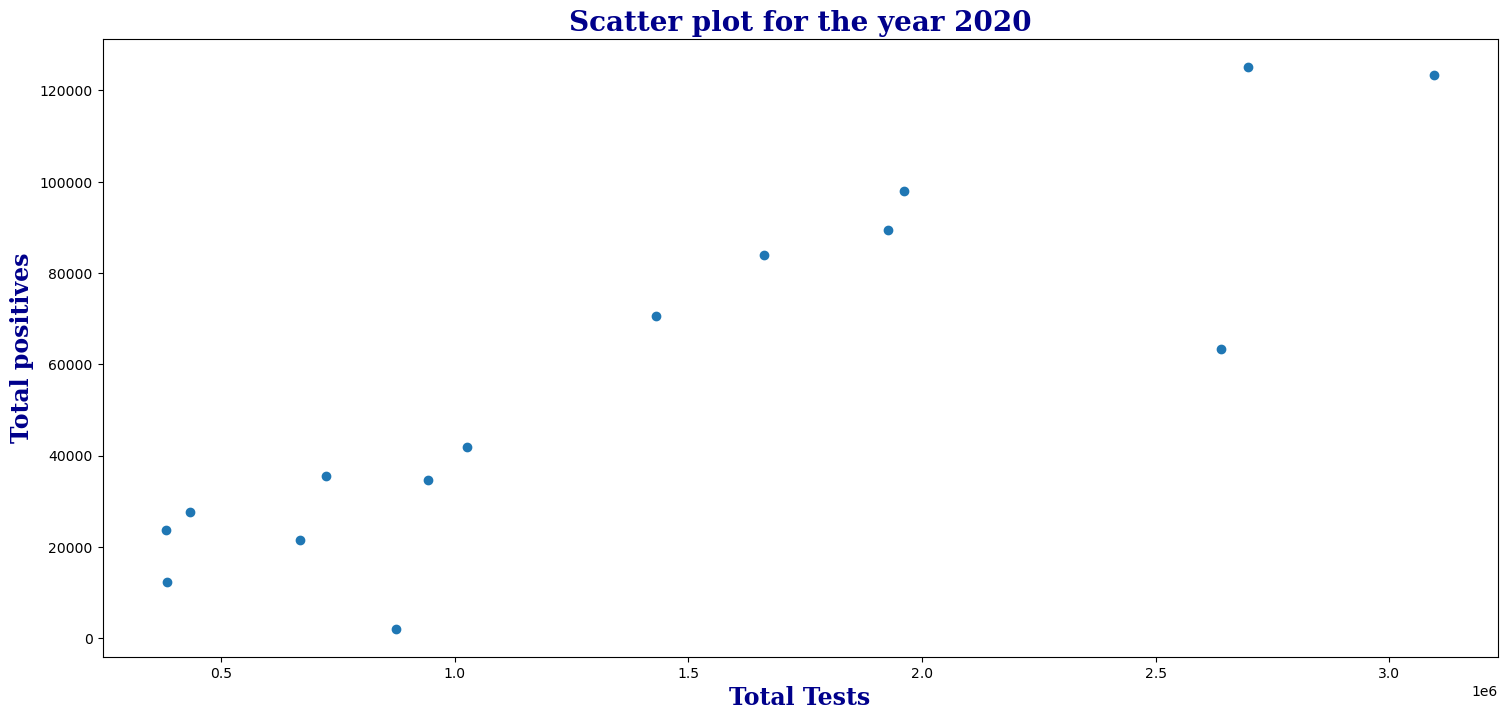

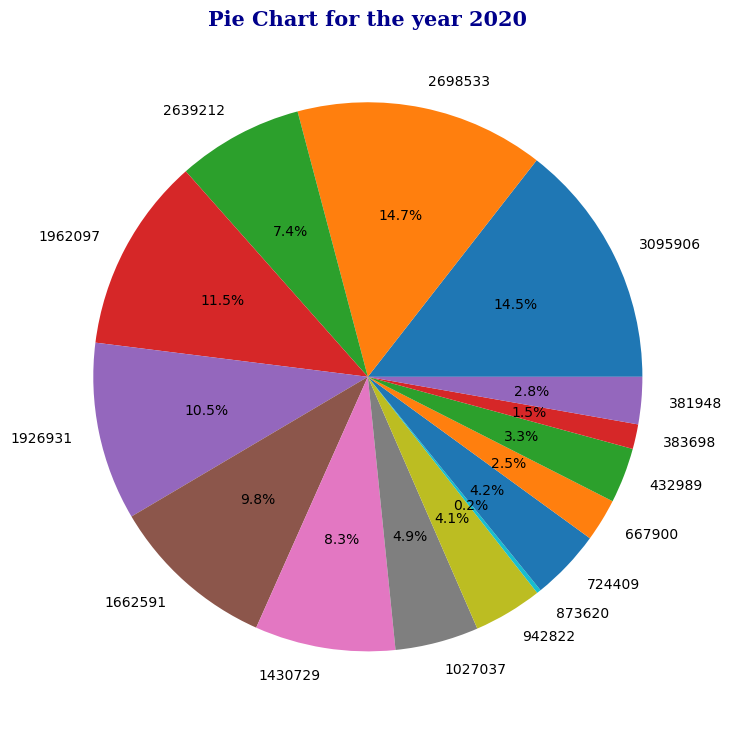

In [25]:
## Scatter plot
plt.figure(figsize=(18, 18),dpi=100)
x = np.array(data_frame["Total_Tests"])
y = np.array(data_frame["Total_positives"])
plt.subplot(2, 1, 1)
plt.scatter(x, y)
font1 = {'family':'serif','color':'darkblue','size':20, 'fontweight':'bold'}
font2 = {'family':'serif','color':'darkblue','size':17, 'fontweight':'bold'}
plt.title("Scatter plot for the year 2020",fontdict = font1)
plt.xlabel("Total Tests", fontdict = font2)
plt.ylabel("Total positives", fontdict = font2)


## Pie chart
plt.figure(figsize=(20, 20),dpi=100)
x = np.array(data_frame["Total_Tests"])
y = np.array(data_frame["Total_positives"])
plt.subplot(2, 1, 2)
plt.pie(y, labels = x, autopct='%1.1f%%')
font1 = {'family':'serif','color':'darkblue','size':15, 'fontweight':'bold'}
plt.title("Pie Chart for the year 2020",fontdict = font1)


### Use Case 3.1: Cumulative positive cases in a month in all the years

In [26]:
sql_statement = """SELECT m.Month, SUM(m.New_Positives)as Total_positives FROM
(SELECT Test_ID, substr(d.Test_Date,7,4) as Year, substr(d.Test_Date,1,2) as Month, 
substr(d.Test_Date,4,2) as Day,r.New_Positives
 FROM COVID_RESULTS r
 INNER JOIN DATE_COUNTY d USING('Test_ID')) m
 GROUP BY m.Month"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,Month,Total_positives
0,01,4993434
1,02,990438
2,03,1159212
3,04,1706862
4,05,639834
5,06,104274
6,07,179580
7,08,446700
8,09,514224
9,10,532707


Text(0.5, 1.0, 'Total positive cases in a month in 2020,2021,2022')

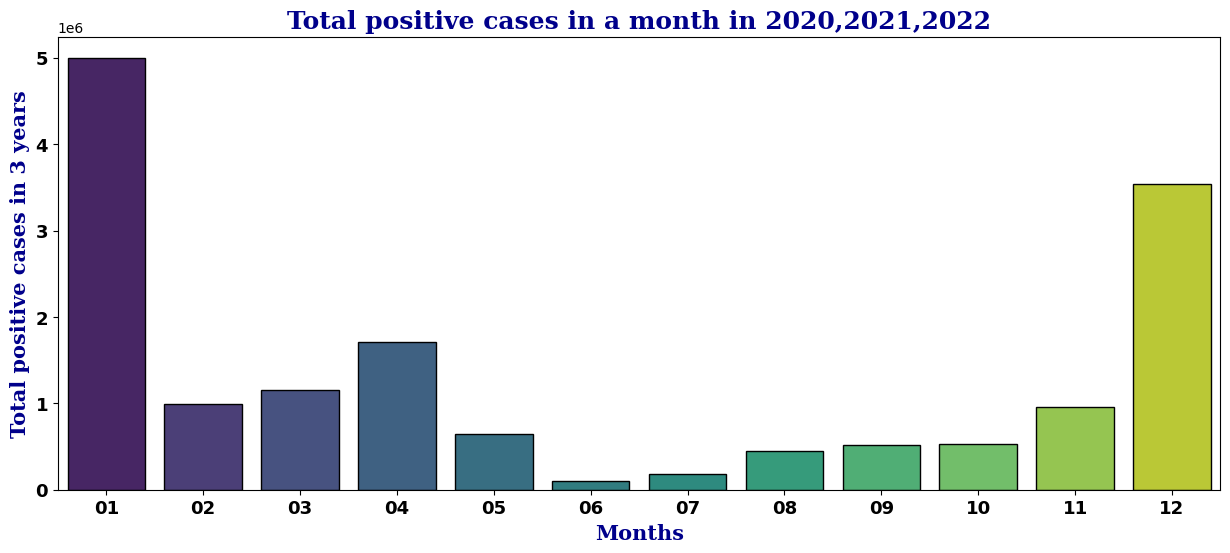

In [27]:
## Bar Graph
plt.figure(figsize=(15,6),dpi=100)
sns.barplot(y = data_frame["Total_positives"],x = data_frame["Month"], palette = "viridis",edgecolor='black')
font1 = {'family':'serif','color':'darkblue','size':18, 'fontweight':'bold'}
font2 = {'family':'serif','color':'darkblue','size':15, 'fontweight':'bold'}
plt.ylabel("Total positive cases in 3 years", fontdict = font2)
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.xlabel("Months", fontdict = font2)
plt.title("Total positive cases in a month in 2020,2021,2022",fontdict = font1)

### Use Case 3.2: Cumulative positive cases in a month in the year 2020

In [28]:
sql_statement = """SELECT m.Month, SUM(m.New_Positives)as Total_positives FROM
(SELECT Test_ID, substr(d.Test_Date,7,4) as Year, substr(d.Test_Date,1,2) as Month, 
substr(d.Test_Date,4,2) as Day,r.New_Positives
 FROM COVID_RESULTS r
 INNER JOIN DATE_COUNTY d USING('Test_ID')) m WHERE m.Year = '2020'
 GROUP BY m.Month"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,Month,Total_positives
0,03,251136
1,04,673806
2,05,190191
3,06,67104
4,07,65064
5,08,59229
6,09,73563
7,10,149112
8,11,436590
9,12,1006338


Text(0.5, 1.0, 'Total positive cases in a month in 2020')

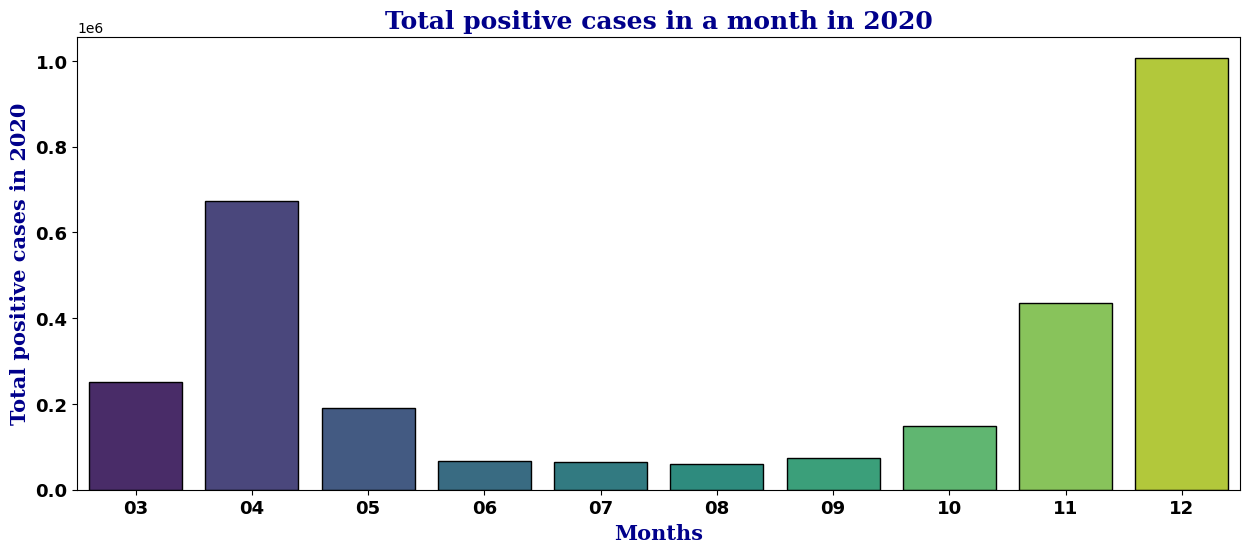

In [29]:
## Bar Graph
plt.figure(figsize=(15,6),dpi=100)
sns.barplot(y = data_frame["Total_positives"],x = data_frame["Month"], palette = "viridis",edgecolor='black')
font1 = {'family':'serif','color':'darkblue','size':18, 'fontweight':'bold'}
font2 = {'family':'serif','color':'darkblue','size':15, 'fontweight':'bold'}
plt.ylabel("Total positive cases in 2020", fontdict = font2)
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.xlabel("Months", fontdict = font2)
plt.title("Total positive cases in a month in 2020",fontdict = font1)

### Use Case 3.3: Cumulative positive cases in a month in the year 2021

In [30]:
sql_statement = """SELECT m.Month, SUM(m.New_Positives)as Total_positives FROM
(SELECT Test_ID, substr(d.Test_Date,7,4) as Year, substr(d.Test_Date,1,2) as Month, 
substr(d.Test_Date,4,2) as Day,r.New_Positives
 FROM COVID_RESULTS r
 INNER JOIN DATE_COUNTY d USING('Test_ID')) m WHERE m.Year = '2021'
 GROUP BY m.Month"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,Month,Total_positives
0,01,1285359
1,02,652548
2,03,691920
3,04,506697
4,05,148086
5,06,37170
6,07,114516
7,08,387471
8,09,440661
9,10,383595


Text(0.5, 1.0, 'Total positive cases in a month in 2021')

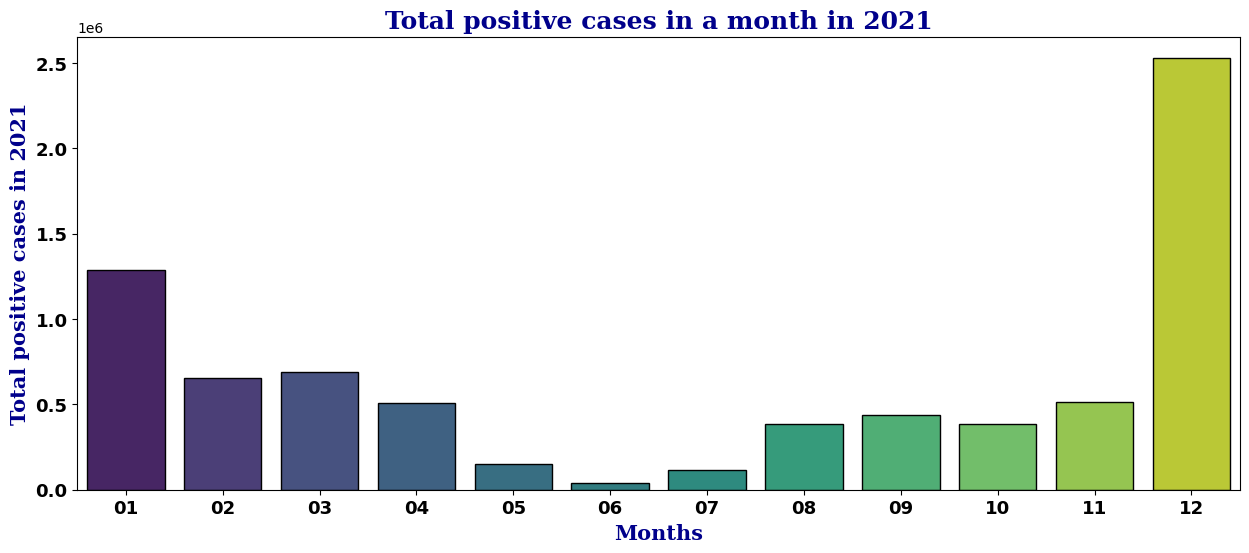

In [31]:
## Bar Graph
plt.figure(figsize=(15,6),dpi=100)
sns.barplot(y = data_frame["Total_positives"],x = data_frame["Month"], palette = "viridis",edgecolor='black')
font1 = {'family':'serif','color':'darkblue','size':18, 'fontweight':'bold'}
font2 = {'family':'serif','color':'darkblue','size':15, 'fontweight':'bold'}
plt.ylabel("Total positive cases in 2021", fontdict = font2)
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.xlabel("Months", fontdict = font2)
plt.title("Total positive cases in a month in 2021",fontdict = font1)

### Use Case 3.4: Cumulative positive cases in a month in the year 2022

In [32]:
sql_statement = """SELECT m.Month, SUM(m.New_Positives)as Total_positives FROM
(SELECT Test_ID, substr(d.Test_Date,7,4) as Year, substr(d.Test_Date,1,2) as Month, 
substr(d.Test_Date,4,2) as Day,r.New_Positives
 FROM COVID_RESULTS r
 INNER JOIN DATE_COUNTY d USING('Test_ID')) m WHERE m.Year = '2022'
 GROUP BY m.Month"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,Month,Total_positives
0,01,3708075
1,02,337890
2,03,216156
3,04,526359
4,05,301557


Text(0.5, 1.0, 'Total positive cases in a month in 2022')

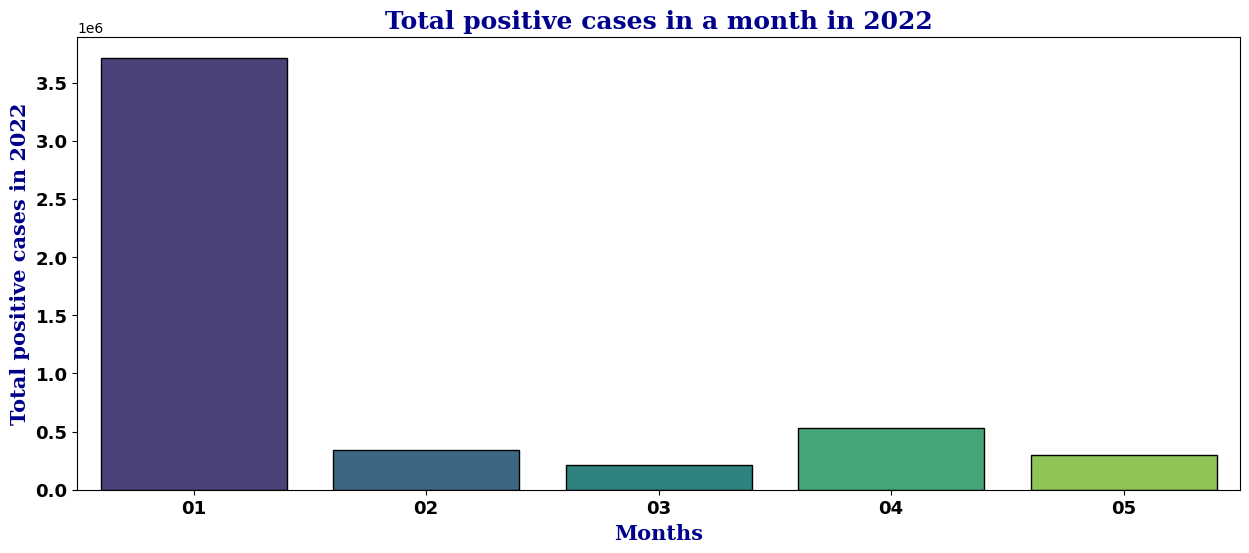

In [33]:
## Bar Graph
plt.figure(figsize=(15,6),dpi=100)
sns.barplot(y = data_frame["Total_positives"],x = data_frame["Month"], palette = "viridis",edgecolor='black')
font1 = {'family':'serif','color':'darkblue','size':18, 'fontweight':'bold'}
font2 = {'family':'serif','color':'darkblue','size':15, 'fontweight':'bold'}
plt.ylabel("Total positive cases in 2022", fontdict = font2)
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold')
plt.xlabel("Months", fontdict = font2)
plt.title("Total positive cases in a month in 2022",fontdict = font1)

### USE CASE 4: Difference in Positive Cases for max affected counties in subsequent years

In [34]:
sql_statement = """
SELECT j.Year,j.Total_positives_in_Kings, j.total_positives_in_Queens
FROM ((SELECT m.Year, SUM(m.New_Positives)as Total_positives_in_Kings FROM
(SELECT Test_ID, g.COUNTY, substr(d.Test_Date,7,4) as Year, substr(d.Test_Date,1,2) as Month, substr(d.Test_Date,4,2) as Day,
    r.New_Positives
 FROM COVID_RESULTS r
 INNER JOIN DATE_COUNTY d USING('Test_ID')
 INNER JOIN COUNTY g ON g.COUNTYID = d.County_ID) m WHERE m.COUNTY = 'Kings'
 GROUP BY m.Year, m.COUNTY) q
 
 INNER JOIN
 
(SELECT w.Year, SUM(w.New_Positives) as Total_positives_in_Queens, w.COUNTY  FROM 
 (SELECT v.New_Positives,k.COUNTY, substr(h.Test_Date,7,4) as Year
 FROM COVID_RESULTS v
 INNER JOIN DATE_COUNTY h USING('Test_ID')
 INNER JOIN COUNTY k ON k.COUNTYID = h.County_ID) w WHERE w.COUNTY = 'Queens'
 GROUP BY w.Year, w.COUNTY) o USING('Year')) j
 

"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,Year,Total_positives_in_Kings,Total_positives_in_Queens
0,2020,123424,125107
1,2021,358905,309231
2,2022,238239,233055


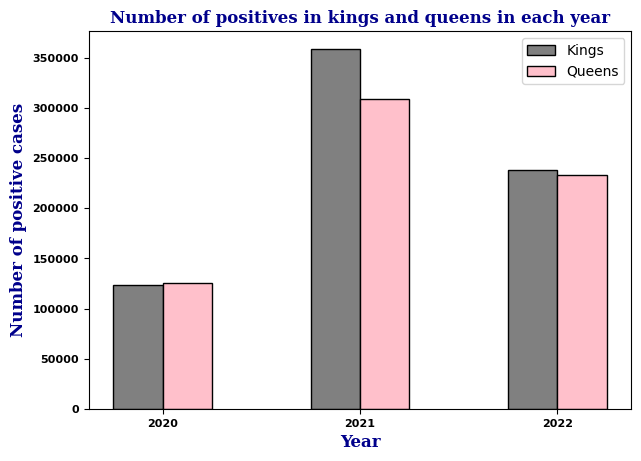

In [35]:
plt.figure(figsize=(7,5),dpi=100)
Kings = np.array(data_frame["Total_positives_in_Kings"])
Queens = np.array(data_frame["Total_positives_in_Queens"])
  
n=3
r = np.arange(n)
width = 0.25
  
plt.bar(r, Kings, color = 'grey',
        width = width, edgecolor = 'black',
        label='Kings')
plt.bar(r + width, Queens, color = 'pink',
        width = width, edgecolor = 'black',
        label='Queens')
font = {'family':'serif','color':'darkblue','size':12, 'fontweight':'bold'}
  
plt.xlabel("Year", fontdict = font)
plt.ylabel("Number of positive cases", fontdict = font)
plt.title("Number of positives in kings and queens in each year", fontdict = font)

plt.xticks(r + width/2,['2020','2021','2022'], fontsize = 8, fontweight = 'bold')
plt.yticks(fontsize = 8, fontweight = 'bold')
plt.legend()
  
plt.show()




## Machine Learning Techniques

## Word Cloud

In [36]:
sql_statement = """SELECT c.COUNTY as County, SUM(r.Total_Number_of_Tests_Performed) as Total_Tests, SUM(r.New_Positives) as Total_positives
FROM COVID_RESULTS r
INNER JOIN DATE_COUNTY d USING('Test_ID')
INNER JOIN COUNTY c ON d.County_ID = c.COUNTYID
INNER JOIN Geography g ON r.GeographyID = g.GeographyID
WHERE d.Test_Date LIKE '%22' AND g.Geography = 'COUNTY' GROUP BY c.COUNTY ORDER BY -Total_positives LIMIT 40;"""
data_frame = pd.read_sql_query(sql_statement, conn_normalized_covid_data)
data_frame

,County,Total_Tests,Total_positives
0,Kings,3727496,238239
1,Queens,2687100,233055
2,New York,2716020,163745
3,Bronx,1648871,128602
4,Nassau,1184678,123020
5,Suffolk,1134662,117761
6,Westchester,868890,77709
7,Erie,575432,75797
8,Onondaga,384093,49554
9,Richmond,589133,48699


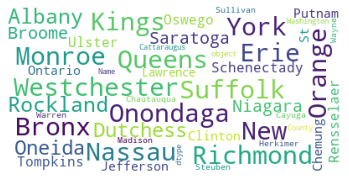

In [38]:
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS



stopwords = set(STOPWORDS)
wordcloud = WordCloud(
background_color='white',
stopwords=stopwords,
max_words=50,
max_font_size=30,
random_state = 42
).generate(str(data_frame['County']))



fig = plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Scree plot elbow for PCA

In [39]:
x=df.iloc[:,:-1].values
y=df.iloc[:,1].values

In [40]:
x

array([[1, 220, 63461, 1591, 1280510, '13.85%'],
       [2, 148, 63241, 1099, 1278919, '15.33%'],
       [3, 112, 63093, 679, 1277820, '16.05%'],
       ...,
       [60148, 0, 0, 0, 0, '0.00%'],
       [60149, 0, 0, 0, 0, '0.00%'],
       [60150, 0, 0, 0, 0, '0.00%']], dtype=object)

In [41]:
xnew=x[:,:5]

In [42]:
y

array([220, 148, 112, ...,   0,   0,   0], dtype=int64)

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(xnew, y, test_size=1/3, random_state=0)

In [44]:
df.columns

Index(['Test_ID', 'New_Positives', 'Cumulative_Number_of_Positives',
       'Total_Number_of_Tests_Performed',
       'Cumulative_Number_of_Tests_Performed', 'Test_Positive_Perc',
       'GeographyID'],
      dtype='object')

In [45]:
X=df['Total_Number_of_Tests_Performed']
Y=df['New_Positives']


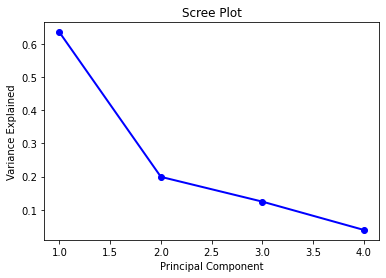

In [46]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
#define scaler
scaler = StandardScaler()

#create copy of DataFrame
scaled_df=df.copy()

#created scaled version of DataFrame
scaled_df=pd.DataFrame(scaler.fit_transform(xnew))

from sklearn.decomposition import PCA

#define PCA model to use
pca = PCA(n_components=4)

#fit PCA model to data
pca_fit = pca.fit(scaled_df)
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [47]:
print(pca.explained_variance_ratio_)


[0.63472358 0.19904295 0.12440331 0.03917287]


In [48]:
0.63507125+0.19904617+0.1244858 #First 3 Principal Components Contribute almost 96%

0.95860322

In [49]:
0.63507125+0.19904617+0.1244858+0.03868455 

0.99728777

###### We can see:
    -The first principal component explains 63.50% of the total variation in the dataset.
    -The second principal component explains 19.90% of the total variation.
    -The third principal component explains 12.44% of the total variation.
    -The fourth principal component explains 3.86% of the total variation.
     *Note that the percentages almost sum to 100%

## PCA

C:\Users\sahit\AppData\Local\Temp/ipykernel_12176/432087477.py:5: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig, elev=-150, azim=110)


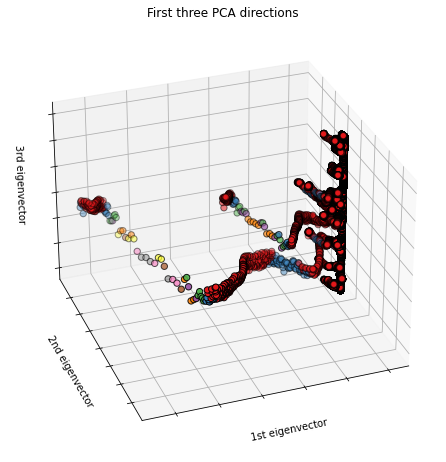

In [50]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(xnew)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [51]:
X_reduced


array([[-5.56973240e+05,  1.06609497e+04, -2.99776255e+04],
       [-5.58573146e+05,  1.05309504e+04, -2.99929129e+04],
       [-5.59678306e+05,  1.04488776e+04, -3.00055883e+04],
       ...,
       [-1.83901020e+06,  4.52160797e+02,  3.02646112e+04],
       [-1.83901020e+06,  4.52153735e+02,  3.02656107e+04],
       [-1.83901020e+06,  4.52146672e+02,  3.02666102e+04]])

## KMeans

In [52]:
from sklearn import preprocessing
X_scaled = preprocessing.scale(X_reduced)
X_scaled 

X_transform = PCA(n_components=3).fit_transform(X_scaled)
X_transform

array([[-0.07415747, -1.73020065,  0.18364356],
       [-0.07437049, -1.7310713 ,  0.18129894],
       [-0.07451764, -1.73179541,  0.17981787],
       ...,
       [-0.24485261,  1.7457969 ,  0.01650622],
       [-0.24485261,  1.74585455,  0.01650637],
       [-0.24485261,  1.74591221,  0.01650652]])

In [53]:
X_scaled.mean(axis=0)


array([ 2.37922271e-16,  5.95292784e-17, -5.18667772e-15])

In [54]:
X_reduced_new = PCA(n_components=3).fit_transform(X_scaled)

In [55]:
X_reduced_new

array([[-0.07415747, -1.73020065,  0.18364356],
       [-0.07437049, -1.7310713 ,  0.18129894],
       [-0.07451764, -1.73179541,  0.17981787],
       ...,
       [-0.24485261,  1.7457969 ,  0.01650622],
       [-0.24485261,  1.74585455,  0.01650637],
       [-0.24485261,  1.74591221,  0.01650652]])

In [56]:
xnew

array([[1, 220, 63461, 1591, 1280510],
       [2, 148, 63241, 1099, 1278919],
       [3, 112, 63093, 679, 1277820],
       ...,
       [60148, 0, 0, 0, 0],
       [60149, 0, 0, 0, 0],
       [60150, 0, 0, 0, 0]], dtype=object)

In [57]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [58]:
distortions = [] 
inertias = [] 
scores=[]
K = range(2,20) 
scores=[]


In [59]:
idx = np.random.randint(10,size=6)

tfIdfKmeans = X_reduced_new[idx,:]


In [60]:
kmeanModel = KMeans(n_clusters=2).fit(tfIdfKmeans ) 


In [61]:
preds = kmeanModel.fit_predict(X_reduced_new)

X_reduced_new =preds


In [62]:
X_reduced_new

array([1, 1, 1, ..., 0, 0, 0])

In [63]:
positives=xnew[:,1]
tests=xnew[:,3]

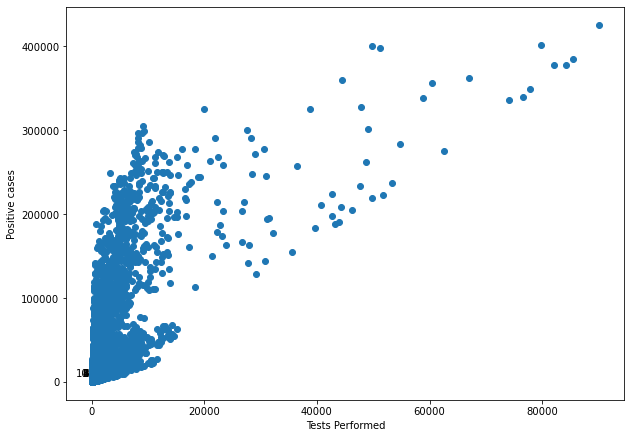

In [64]:
import matplotlib.pyplot as plt

labels = range(1, 11)
plt.figure(figsize=(10, 7))
plt.subplots_adjust(bottom=0.1)
plt.scatter(positives,tests, label='True Position')

for label, m, n in zip(labels, xnew[:, 0], xnew[:, 1]):
    plt.annotate(
        label,
        xy=(m, n), xytext=(-3, 3),
        textcoords='offset points', ha='right', va='bottom')
plt.xlabel('Tests Performed') 
plt.ylabel('Positive cases')     
plt.show()


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt

linked = linkage(X_reduced, 'single')

labelList = range(10, 7)

plt.figure(figsize=(100, 7))
dendrogram(linked,
            orientation='top',
            labels=labelList,
            distance_sort='descending',
            show_leaf_counts=True)
plt.show()

In [ ]:
from scipy.spatial.distance import cdist 
for k in K: 
    
    kmModel =  KMeans(n_clusters=k,max_iter=10).fit(tfIdfKmeans )
    preds = kmModel.fit_predict(tfIdfKmeans)
    centers = kmModel.cluster_centers_
    distortions.append(sum(np.min(cdist(tfIdfKmeans, centers,'euclidean'),axis=1)) / tfIdfKmeans .shape[0]) 
plt.figure( figsize=(90,60))  
plt.plot(K,distortions, 'gx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortions') 
plt.title('The Elbow Method using distortions') 
plt.show() 
plt.savefig('KmeansElbow.png')

#### K-MEans issue

## Linear Regression model

In [65]:
##raw data analysis 
df = pd.read_csv('New_York_State_Statewide_COVID-19_Testing.csv')
print("types:\n", df.dtypes, '\n')
print("describe:", df.describe(), '\n')
print("head:", df.head(20), '\n')
print("Last 20 records: ", df.tail(20), '\n')
print("index:", df.index, '\n')
print("columns:", df.columns, '\n')
print("count:", df.count(), '\n')

types:
 Test Date                               object
County                                  object
New Positives                            int64
Cumulative Number of Positives           int64
Total Number of Tests Performed          int64
Cumulative Number of Tests Performed     int64
Test % Positive                         object
Geography                               object
dtype: object 

describe:        New Positives  Cumulative Number of Positives  \
count   60150.000000                    6.015000e+04   
mean      261.931122                    7.647635e+04   
std      1741.269437                    3.196346e+05   
min         0.000000                    0.000000e+00   
25%         3.000000                    9.450000e+02   
50%        20.000000                    6.074000e+03   
75%        90.000000                    3.429225e+04   
max     90132.000000                    5.251719e+06   

       Total Number of Tests Performed  Cumulative Number of Tests Performed  
count 

In [66]:
## string to category, normalization as well
df.dropna()

for i in df.select_dtypes(include=object).columns:
    df[i] = df[i].astype('category').cat.codes

print("Converted the columns with datatype string to categorical\n", df.dtypes,'\n')
print(df.head(5), '\n')


for i in df.select_dtypes(include=float).columns:
    print("Columns: ",i)
    print("Max: ", df[i].max(), "Min: ",df[i].min())
    df[i]=(df[i]-df[i].min())/(df[i].max()-df[i].min())

Converted the columns with datatype string to categorical
 Test Date                               int16
County                                   int8
New Positives                           int64
Cumulative Number of Positives          int64
Total Number of Tests Performed         int64
Cumulative Number of Tests Performed    int64
Test % Positive                         int16
Geography                                int8
dtype: object 

   Test Date  County  New Positives  Cumulative Number of Positives  \
0        493       0            220                           63461   
1        490       0            148                           63241   
2        557       0            112                           63093   
3        554       0            112                           62981   
4        551       0            129                           62869   

   Total Number of Tests Performed  Cumulative Number of Tests Performed  \
0                             1591                    

In [67]:
## data testing and training
Y=df['New Positives']
X=df[['County','Total Number of Tests Performed','Test % Positive','Geography']]

n=X.shape
len_train=(n[0]*80)//100
len_test=n[0]-len_train
print(len_train,len_test)

X_train=X[:len_train]
Y_train=Y[:len_train]
X_test=X[len_train:]
Y_test=Y[len_train:]

print(Y_test.head())

48120 12030
48120    413
48121    432
48122    296
48123    146
48124    298
Name: New Positives, dtype: int64


In [68]:
## ols model, training
def ols(X,Y):
    X_t = np.transpose(X)
    #X_t_X = n_t,Xp.dot(X)
    X_t_X = np.dot(X_t,X)
    X_t_X_Inverse = np.linalg.inv(X_t_X)
    w = np.dot((np.dot(X_t_X_Inverse,X_t)),Y)
    return w

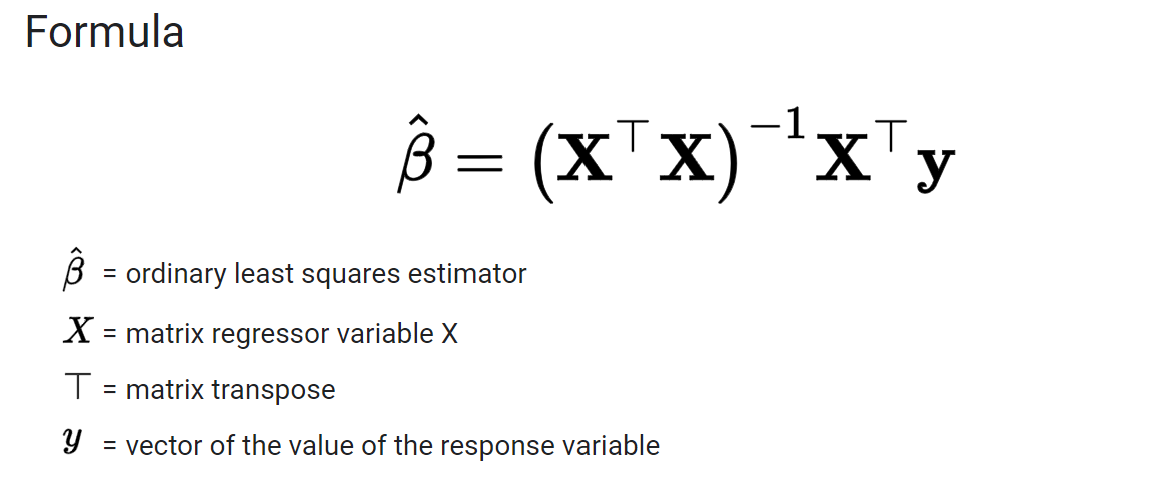

In [70]:
## model testing
Weights = ols(X_test,Y_test)
print("Weight Vector: ", Weights)

b = 1
y_hat = np.matmul(X_test,Weights.reshape(-1,1)) + b #prediction formulae

Weight Vector:  [-8.76424383e-01  4.98188294e-02  4.94571598e-02 -5.52797847e+01]


In [71]:
## error
N = X_test.shape[0]
MSE = np.sqrt(np.sum(np.square(np.subtract(Y_test.values.reshape(12030,1),y_hat))))/N
print("Mean Square Error: ", MSE.to_string(index = False))

Mean Square Error:  2.548192


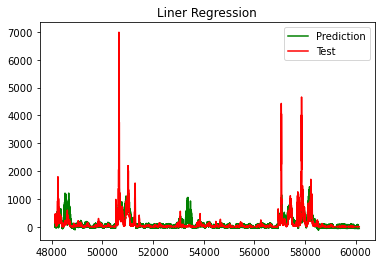

In [60]:
fig, ax = plt.subplots()

plt.title("Liner Regression")
ax.plot(y_hat, color = 'green', label = 'Prediction')
ax.plot(Y_test, color = 'red', label = 'Test')
ax.legend(loc = 'upper right')
plt.show()